<a href="https://colab.research.google.com/github/hareidx/FASTAI_HAREID/blob/main/FASTAI_Week_01_My_Own_Take_Version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAST AI Week 01 - My Own Take Version 3

In [8]:
### This version will try to have 3 different image types

In [1]:
!pip install -Uqq fastai

In [2]:
# begin imports
from fastai.vision.all import *
from fastcore.all import *
from fastdownload import download_url
import time

In [3]:
# create function for searching for and locating images from Duck Duck Go
def search_images(term, max_images=350) -> "L(urls)[:max_images]":
  url = 'https://duckduckgo.com/'
  res = urlread(url,data={'q':term})
  searchObj = re.search(r'vqd=([\d-]+)\&', res)
  requestUrl = url + 'i.js'
  params = dict(l='us=en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
  urls,data = set(), {'next':1}
  while len(urls)<max_images and 'next' in data:
    data = urljson(requestUrl, data=params)
    urls.update(L(data['results']).itemgot('image'))
    requestUrl = url + data['next']
    time.sleep(0.2)
  return L(urls)[:max_images]
  
def search(term: str) -> None:
  """ Search for a single thing """
  urls = search_images(term, max_images=1)
  urls[0]
  dest = f'{term}.jpg'
  #dest = term+'.jpg'
  download_url(urls[0], dest, show_progress=False)
  im = Image.open(dest)
  im.to_thumb(256,256)

def prediction(learn: vision_learner, image: str) -> None:
  is_base,_,probs = learn.predict(PILImage.create(baseimage))
  print(f'This is a {is_base}.')
  print(f'Probability it is a {base}: {probs[0]:.4f}')

def begin_search(base: str, comparable1: str, comparable2: str) -> None:
  """Run a search on a base image type and its comparable/anti"""
  search(base)
  search(comparable1)
  search(comparable2)

  searches = base, comparable1, comparable2
  path = Path(f'{base}_or_{comparable1}_or_{comparable2}')
  for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

  # remove failed downloads
  failed = verify_images(get_image_files(path))
  failed.map(Path.unlink)
  print(f'There were {len(failed)} failed images')    

  # set up model
  dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
  ).dataloaders(path)

  dls.show_batch(max_n=10)
  #train_model(base, dls)
  learn = vision_learner(dls, resnet18, metrics=error_rate)
  learn.fine_tune(10)
  prediction(learn, f'{base}.jpg')
  prediction(learn, f'{comparable1}.jpg')
  prediction(learn, f'{comparable2}.jpg')


There were 14 failed images
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


NameError: name 'train_model' is not defined

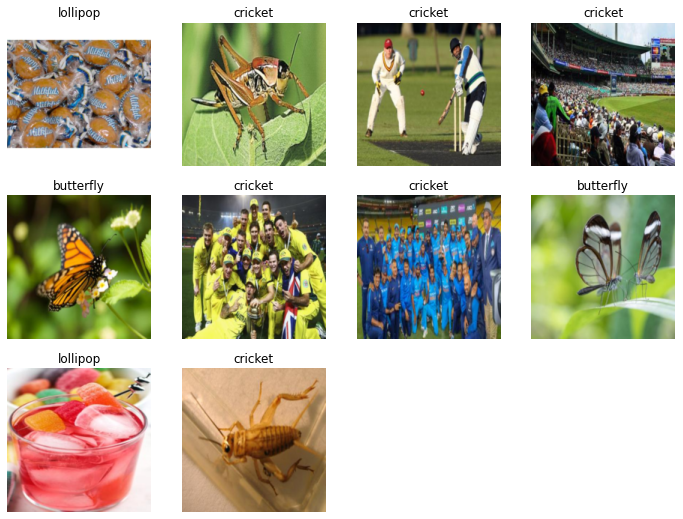

In [4]:
base='butterfly'
comparable1='lollipop'
comparable2='cricket'
begin_search(base,comparable1,comparable2)